# Direct information from a multiple sequence alignment

[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/nihcompmed/fem/master?filepath=doc%2Fnotebooks%2Fdiscrete%2F03_direct_info_from_msa.ipynb)

In this example, we compute coupling strengths between residues of the CRISPR-Cas9 protein amino acid sequence from multiple sequence alignment data. We demonstrate that a statistic called *direct information* [[1]](https://doi.org/10.1073/pnas.1111471108) computed from these couplings is predictive of contacts in observed 3D conformations of the sequence.

We start by loading the necessary packages and functions. We collect and parse MSA data from the [Pfam database](https://pfam.xfam.org/) using the `parse_pfam` function in [this script](../../static/parse_pfam.py). The function downloads the full current release of the Pfam database, creates a local directory structure with the MSA data for each family and any cross-references from sequences in each family to structures in the [Protein Data Bank](https://www.rcsb.org/), then returns pandas DataFrames that detail information about the MSAs and PDB cross-references.

The MSA and PDB cross-reference data for the protein family/MSA with Pfam accession code PFXXXXX are stored in files `msa.npy` and `pdb_refs.npy`  (if cross-references are found) in the `Pfam-A.full/PFXXXXX` subdirectory of `data_dir` defined below.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import fem, sys, os, time, Bio.PDB, nglview, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
data_dir = '../../../data/msa'
sys.path.append(data_dir)
from parse_pfam import parse_pfam
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)
%matplotlib inline

Next, we get pandas DataFrames `pfam` and `pdb_refs` detailing information for all protein families in the Pfam database and references from MSA sequences to PDB structures.

In [2]:
pfam, pdb_refs = parse_pfam(data_dir)
print 'total MSAs: %i, total PDB refs: %i' % (pfam.shape[0], pdb_refs.shape[0])

total MSAs: 16479, total PDB refs: 207746


Each row in `pfam` contains information about a single MSA. The columns of `pfam` are `res`: the number of residues in each sequence of the alignment, `seq`: the number of sequences in the alignment. Now let's add a column `size=res*seq` and sort by that column to see which families contain the most data.

In [3]:
pfam['size'] = pfam['res'] * pfam['seq']
pfam.sort_values(by='size', ascending=False, inplace=True)
pfam.head()

,res,seq,pdb_refs,size
PF00005,2386,369723,407,882159078
PF00069,3194,236455,3910,755237270
PF07690,3427,214283,23,734347841
PF00067,4853,85020,768,412602060
PF00501,3767,87704,145,330380968


Each row in the PDB references table `pdb_refs` contains information about a cross-reference between a protein family sequence in the Pfam database and a protein structure in the PDB database. The columns of the table are `seq`: the index (starting at 0) of a sequence in the protein family, `uniprot_id`: the ID of the sequence in the [UniProtKB](https://www.uniprot.org/help/uniprotkb) database, `uniprot_start`/`uniprot_end`: the start and end residue positions of the UniProtKB sequence that appears in the MSA, `pdb_id`: the PDB ID, `chain`: the PDB protein structure chain, `pdb_start`/`pdb_end`: the start and end residue positions of the PDB sequence that appears in the MSA. Let's create a column `res` that contains the length of the sequence and sort by that column.

In [4]:
pdb_refs['res'] = pdb_refs['pdb_end'] - pdb_refs['pdb_start'] + 1
pdb_refs.sort_values(by='res', ascending=False, inplace=True)
pdb_refs.head()

,seq,uniprot_id,uniprot_start,uniprot_end,pdb_id,chain,pdb_start,pdb_end,res
PF11894,578,NU205_HUMAN,14,1684,5IJN,J,14,1684,1671
PF11894,578,NU205_HUMAN,14,1684,5IJN,P,14,1684,1671
PF11894,578,NU205_HUMAN,14,1684,5IJN,D,14,1684,1671
PF11894,578,NU205_HUMAN,14,1684,5IJN,V,14,1684,1671
PF02463,2434,SMC1_YEAST,3,1213,1W1W,C,3,1213,1211


We'll examine the particular protein family with Pfam accesion code PF16592. This protein family corresponds to the REC lobe of CRISPR-associated endonuclease Cas9. The REC lobe and the NUC lobe of Cas9 fold to present a positively charged groove at their interface which accommodates the negatively charged sgRNA: target DNA heteroduplex. [[2]](https://www.ncbi.nlm.nih.gov/pubmed/24529477) We'll isolate the family of interest from the `pfam` DataFrame in the `fam` variable.

In [5]:
# Cas 9 family accesion code
ac = 'PF16592'
# store the family of interest in the 'fam' variable
fam = pfam.loc[ac]
print 'size rank: %i of %i' % (pfam['size'].rank(ascending=False)[fam.name].astype(int), pfam.shape[0])

# local directory containing data for this MSA
fam_dir = os.path.join(data_dir, 'Pfam-A.full', fam.name)
# the residue symbols array that is the MSA
msa = np.load(os.path.join(fam_dir, 'msa.npy'))

# determine which residues are the same across all sequences, excluding gaps
aa = np.array([np.unique(s) for s in msa])
one_aa = np.array([len(a) == 1 for a in aa])
two_aa = np.array([len(a) == 2 for a in aa])
missing_aa_res = np.array(['-' in a for a in aa])
conserved_residues = one_aa | (two_aa & missing_aa_res)

# the number of unique amino acids (or gap symbol) that appear at each residue
m = np.array([len(a) for a in aa])
m = m[~conserved_residues]
n_residues = m.shape[0]

pfam[pfam.index == ac]

size rank: 7142 of 16479


,res,seq,pdb_refs,size
PF16592,1079,146,21,157534


One can classify a residue from the perspective of the MSA as a conserved residue, meaning that in every sequence of the MSA, either a gap or the same amino acid is observed. One can also classify a residue from the perspective of the sequence as a gap, i.e. an insertion that Pfam's aligning algorithm made in the sequence in order to compare like residues across sequences. Therefore, each sequence-residue symbol is in one of four classes according to whether it is a conserved residue or not and where it is a gap or not. We color code each sequence-residue symbol for the MSA of interest.

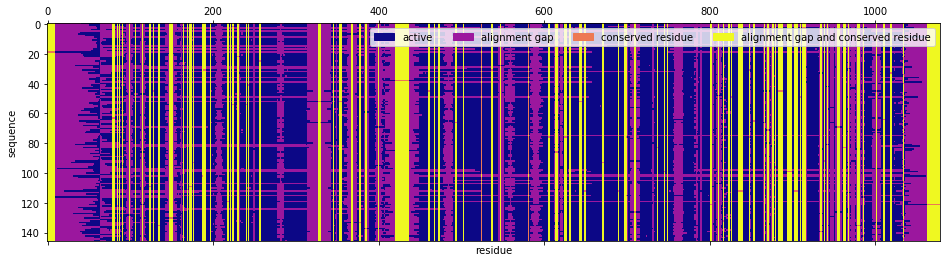

In [6]:
code = np.zeros(msa.shape, dtype=int)
code[conserved_residues] = 2
for j, s in enumerate(msa.T):
    code[s == '-', j] += 1        
    
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.set_ylabel('sequence')
ax.set_xlabel('residue')
cmap = plt.cm.get_cmap('plasma', 4)
ax.matshow(code.T, aspect='auto', cmap=cmap)
labels = ['active', 'alignment gap', 'conserved residue', 'alignment gap and conserved residue']
handles = [patches.Patch(color=cmap(i), label=labels[i]) for i in range(4)]
plt.legend(handles=handles, ncol=4)
plt.show()

Now, we compute the residue coupling strengths and the direct information from the MSA. The MSA is a set of sequences $\text{MSA}=\{s_1,\ldots,s_n\}$ and each nonconserved residue $r_i$, $i=1,\ldots,m$, in the alignment takes

$$m_i = \left|\{a : r_i=a\text{ for some sequence }s=(r_1,\ldots,r_m)\in\text{MSA}\}\right|$$

unique empircal values in the alignment. In the following, let $M_i=\sum_{\tilde{i}<i}m_{\tilde{i}}$ for $i=1,\ldots,m$ and let $e_i$ denote the $i^{th}$ canonical basis vector of the shape implied by context.

We use FEM to infer the couplings $W$ assuming that the probability of residue $r_i$ being amino acid $a_k$ for any sequence with one-hot encoding $\sigma$ is given by

$$p(r_i=a_k~|~\{r_1,\ldots,r_n\}\setminus \{r_i\})={\exp e_{M_i+k}^TW\sigma\over\sum_{j=1}^{m_i}\exp e_{M_i+j}^TW\sigma},\quad i=1,\ldots,m,~k=1,\ldots,m_i.$$

Specifically, we call `fem.discrete.model.fit(msa[~conserved_residues])` below, where `msa` is an array of symbols with each row storing residue data and each column storing sequence data, to return $W$ and the running discrepancies from the fit.

After computing $W$, we compute the *direct information* for each pair of nonconserved residues. The direct information of residues $r_i$ and $r_j$ is

$$DI(r_i, r_j)=\sum_{k_1=1}^{m_{i_1}}\sum_{k_2=1}^{m_{i_2}} p(r_{i_1}=a_{k_1}, r_{i_2}=a_{k_2}) \ln {p(r_{i_1}=a_{k_1}, r_{i_2}=a_{k_2}) \over p(r_{i_1}=a_{k_1})~p(r_{i_2}=a_{k_2})}$$

where the joint and marginal probablities are computed over subsequences containing only residues $r_i$ and $r_j$:

$$p(r_{i_1}=a_{k_1}, r_{i_2}=a_{k_2})={\exp e_{M_{i_1}+k_1}^TWe_{M_{i_2}+k_2} \over 
\sum_{j_1=1}^{m_{i_1}}\sum_{j_2=1}^{m_{i_2}}\exp e_{M_{i_1}+j_1}^TWe_{M_{i_2}+j_2}},$$

$$p(r_{i_1}=a_{k_1})={\sum_{k_2=1}^{m_{i_2}} p(r_{i_1}=a_{k_1}, r_{i_2}=a_{k_2}) \over \sum_{k_1=1}^{m_{i_1}}\sum_{k_2=1}^{m_{i_2}}p(r_{i_1}=a_{k_1}, r_{i_2}=a_{k_2})},$$

and $p(r_{i_2}=a_{k_2})$ is defined similarly.

We plot the running discrepancies from the fit and heat maps of $W$ and the direct information below.

fit time: 17.29 sec


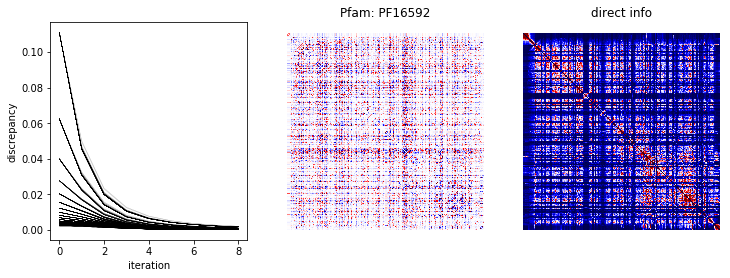

In [7]:
def direct_information(msa, cache=True):

    w_file = os.path.join(fam_dir, 'w.npy')
    disc_file = os.path.join(fam_dir, 'disc.npy')
    if cache and os.path.exists(w_file) and os.path.exists(disc_file):
        w = np.load(w_file)
        disc = np.load(disc_file)
    else:
        model = fem.discrete.model()
        start = time.time()
        model.fit(msa[~conserved_residues], iters=10)
        end = time.time()
        print 'fit time: %.02f sec' % (end-start,)
        w = np.hstack(model.w.values())
        disc = model.disc
        np.save(w_file, w)
        np.save(disc_file, disc)

    direct_info_file = os.path.join(fam_dir, 'direct_info.npy')
    if cache and os.path.exists(direct_info_file):
        direct_info = np.load(direct_info_file)
    else:
        mm = np.insert(m.cumsum(), 0, 0)
        w_idx = np.vstack((mm[:-1], mm[1:])).T
        direct_info = np.zeros((n_residues, n_residues))
        for i, ii in enumerate(w_idx):
            for j, jj in enumerate(w_idx):
                p = np.exp(w[ii[0]:ii[1], jj[0]:jj[1]])
                pi, pj = p.sum(axis=1), p.sum(axis=0)
                p /= p.sum()
                pi /= pi.sum()
                pj /= pj.sum()
                direct_info[i,j] = (p*np.log(p/np.outer(pi, pj))).sum()
        np.save(direct_info_file, direct_info)

    return direct_info, w, disc

direct_info, w, disc = direct_information(msa, cache=False)

fig, ax = plt.subplots(1, 3, figsize=(12,4))
for d in disc:
    ax[0].plot(d, 'k-', lw=0.1)
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('discrepancy')
scale = 1e-1 * np.abs(w).max()
ax[1].matshow(w, cmap='seismic', vmin=-scale, vmax=scale)
ax[1].set_title('Pfam: %s' % (fam.name,))
scale = 1e-1 * np.abs(direct_info).max()
ax[2].matshow(direct_info, cmap='seismic', vmin=0, vmax=scale)
ax[2].set_title('direct info')
for a in ax[1:]:
    a.axis('off')
plt.show()

Next, we examine the extent to direct information is predictive of residue contacts of the 3D conformations of sequences in the MSA. Several sequences in this family contain cross-references to PDB structures. We'll isolate these references from the `pdb_refs` DataFrame in the `refs` variable.

In [8]:
refs = pdb_refs[pdb_refs.index.str.contains(fam.name)]
refs.head()

,seq,uniprot_id,uniprot_start,uniprot_end,pdb_id,chain,pdb_start,pdb_end,res
PF16592,70,CAS9_STRP1,181,712,4OO8,A,181,712,532
PF16592,70,CAS9_STRP1,181,712,4CMQ,A,181,712,532
PF16592,70,CAS9_STRP1,181,712,4OO8,D,181,712,532
PF16592,70,CAS9_STRP1,181,712,4ZT0,A,181,712,532
PF16592,70,CAS9_STRP1,181,712,5F9R,B,181,712,532


Next, we overlay the greatest direct information pairs on the contact maps of the PDB structures cross-referenced from sequences in the MSA. We indicate the percentage of the greatest direct information pairs that are contacts of the PDB in the title of each subplot. A PDB contact map is a binary image where a pixel value is 1 if the corresponding pair of residues is less than a distance threshold (we use 10 angstroms below) and 0 otherwise.

Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4oo8.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4cmq.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4oo8.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4zt0.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb5f9r.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4un4.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4zt0.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb5fw2.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb5b2t.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4un5.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4cmp.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4cmq.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb5fw3.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb5fq5.ent' 
Struct

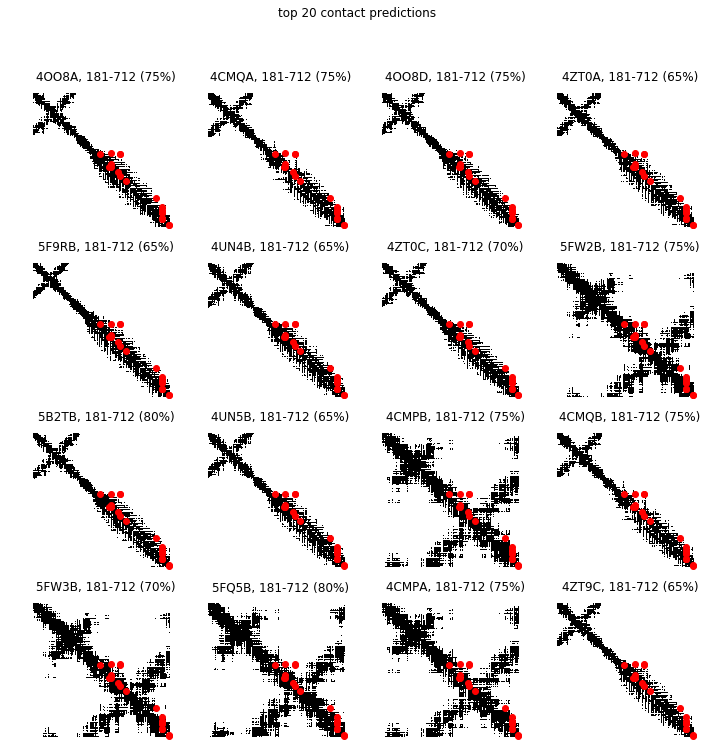

In [9]:
def contact_map(ref, dist_thresh=10):
    seq = msa[:,ref.seq]
    pdb_file = pdb_list.retrieve_pdb_file(ref.pdb_id, pdir=fam_dir, file_format='pdb')
    chain = pdb_parser.get_structure(ref.pdb_id, pdb_file)[0][ref.chain]
    coords = np.array([a.get_coord() for a in chain.get_atoms()])
    coords = coords[ref.pdb_start-1:ref.pdb_end]
    missing_aa_seq = seq == '-'
    coords = coords[~conserved_residues[~missing_aa_seq]]
    return distance_matrix(coords, coords) < dist_thresh

def predict_contacts(seq, direct_info, top, k=2):
    missing_aa_seq = seq == '-'
    di_idx = np.arange((~conserved_residues).sum())
    di_idx = di_idx[~missing_aa_seq[~conserved_residues]]
    di = direct_info[np.ix_(di_idx, di_idx)]
    mask = np.triu(np.ones(di.shape[0], dtype=bool), k=k)
    thresh = np.sort(np.abs(di)[mask])[-top]
    di[~mask] = 0
    predicted_contacts = np.where(di >= thresh)
    return predicted_contacts

top = 20
max_tp = 0
best_ref = refs.iloc[0]

n_refs = refs.shape[0]
r, c = int(1+(n_refs-1)/4.), 4
w, h = 12, 3*r
fig = plt.figure(figsize=(w,h))
for i in range(refs.shape[0]):
    ref = refs.iloc[i]
    seq = msa[:, ref.seq]
    contacts = contact_map(ref)
    predicted_contacts = predict_contacts(seq, direct_info, top)
    tp = contacts[predicted_contacts].sum()
    if tp > max_tp:
        max_tp = tp
        best_ref = ref

    ax = fig.add_subplot(r, c, i+1)
    ax.matshow(contacts, cmap='Greys', aspect='auto')
    ax.scatter(*predicted_contacts[::-1], c='r')
    ax.set_title('%s%s, %i-%i (%02.0f%%)' % (ref.pdb_id, ref.chain, ref.pdb_start, ref.pdb_end, 100.*tp/float(top)))
    ax.axis('off')
    
plt.suptitle('top %i contact predictions' % (top,))
plt.show()

For the PDB with the most correctly predicted contacts, we visualize the greatest direct information pairs on the PDB structure.

In [10]:
ref = best_ref
seq = msa[:, ref.seq]
predicted_contacts = predict_contacts(seq, direct_info, top)

missing_aa_seq = seq == '-'
res = np.arange(ref.pdb_start-1, ref.pdb_end)
res = res[~conserved_residues[~missing_aa_seq]]
res = [res[i] for i in predicted_contacts]

pdb_file = pdb_list.retrieve_pdb_file(ref.pdb_id, pdir=fam_dir, file_format='pdb')
chain = pdb_parser.get_structure(ref.pdb_id, pdb_file)[0][ref.chain]
pdb_res = [r.get_id()[1] for r in chain.get_residues()]

view = nglview.show_biopython(chain)
colors = np.array(['0xFFFFFF'] * len(chain))
for i, r in enumerate(pdb_res):
    if r in res[0]:
        colors[i] = '0xFF0000'
    elif r in res[1]:
        colors[i] = '0x00FF00'
colors = list(colors)
view._set_color_by_residue(colors)
view.display()
view

Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb5b2t.ent' 


NGLWidget()

To further assess the extent to which direct information is predictive of protein contacts, we compute the receiver operating characteristic (ROC) curve that results from varying the number of predicted contacts. The ROC curve is the true positive rate, i.e. the number of correctly predicted contacts divided by the total number of contacts, versus the false positive rate, i.e. the number of incorrectly predicted contacts divided by the total number of noncontacting residue pairs. A perfect binary classifier has an area under the ROC curve equal to 1.

Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4oo8.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4cmq.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4oo8.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4zt0.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb5f9r.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4un4.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4zt0.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb5fw2.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb5b2t.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4un5.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4cmp.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb4cmq.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb5fw3.ent' 
Structure exists: '../../../data/msa/Pfam-A.full/PF16592/pdb5fq5.ent' 
Struct

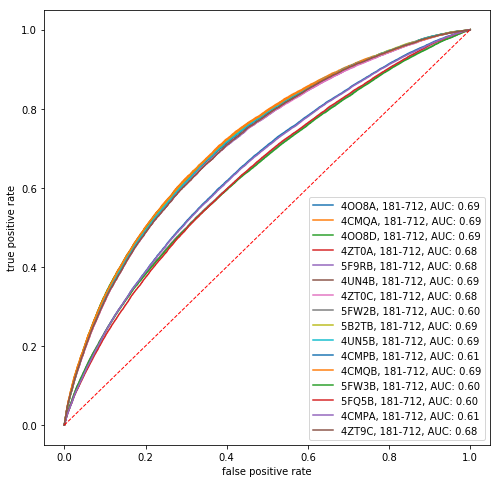

In [11]:
def roc(x, c):
    mask = np.triu(np.ones(di.shape[0], dtype=bool), k=2)
    order = x[mask].argsort()[::-1]
    c_flat = c[mask][order]
    tp = np.cumsum(c_flat, dtype=float)
    fp = np.cumsum(~c_flat, dtype=float)
    tp /= tp[-1]
    fp /= fp[-1]
    return fp, tp

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for i in range(refs.shape[0]):
    ref = refs.iloc[i]
    seq = msa[:, ref.seq]
    missing_aa_seq = seq == '-'
    di_idx = np.arange((~conserved_residues).sum())
    di_idx = di_idx[~missing_aa_seq[~conserved_residues]]
    di = direct_info[np.ix_(di_idx, di_idx)]
    contacts = contact_map(ref)
    fp, tp = roc(di, contacts)
    auc = tp.sum() / tp.shape[0]
    ax.plot(fp, tp, label='%s%s, %i-%i, AUC: %.02f' % (ref.pdb_id, ref.chain, ref.pdb_start, ref.pdb_end, auc))

grid = np.linspace(0, 1)
ax.plot(grid, grid, 'r--', lw=1)
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
plt.legend()
plt.show()